In [4]:
import matplotlib.pyplot as plt
import numpy as np

from qiskit.visualization import plot_histogram

#Tket port
from pytket import Circuit, OpType
from pytket.circuit import CircBox, QControlBox
from pytket.circuit.display import render_circuit_jupyter
from pytket.extensions.qiskit import AerBackend

from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction

# A Tket Implementation of Shor's Algorithm

Shor's algorithm purpose is to factor a composite number $N=p\cdot q$. Therefore, it receives as input a positive number $N$, and returns a factor of $N$.



**Time Complexity**: If $d$ is the number of digits of N, the time complexity of Shor's algorithm is given by $\widetilde{\mathcal{O}}(d^3)$ while the best known algorithm has time complexity of $\widetilde{\mathcal{O}}(2^{d^\frac{1}{3}})$.

## Motivation – RSA Cryptosystem 

Bob wants to receive a encoded message from Alice such that only he can read it. What can he do?

1. He picks two very large (200+ bit) prime numbers $p$ and $q$
2. He sends Alice their product $N=pq$ and an encoding constant $c$ through a public channel

**Note:** $c$ must have no factors in common with $\phi(N)$, where $\phi$ is the Euler totient function. Also, $p$ and $q$ seperately must remain private. This is not a hard premise to satisfy, as factoring a ~400-bit number is unfeasible with currently available computers.

> TODO

## Classical Period Finding Algorithm

1. Pick a random number $1 <a < N$

2. Compute the greatest common divisor of $a$ and $N$, $\gcd{(a,N)}$.

$\gcd{(a,b)}$ is implemented with the Euclidean algorithm in $\mathcal{O}(log(min(a,b)))$ time.

3a. In the lucky case that $\gcd{(a,N)} \neq 1$, we would get a divisor of $N$: $p=\gcd{(a,N)}$. 

3b. Otherwise, if $\gcd{(a,N)} = 1$, define the function $f_a(x) = a^x \mod N$, where $x \in \mathbb{N}$.      

From here on, we omit the subscript $a$, which is implicit.

4. The function $f(x)$ is periodic with period $1< r < N$. Compute $r$.

**Definition** (Period): $r \in \mathbb{N}$ is the smallest integer such that $f(x+r)=f(x) ~~~~  \forall x \in \mathbb{N}$
 
We'll shortly see that knowing $r$ allows us to compute a divisor of  $N$ with high probability (depending on which $a$ we picked in step 1.)

5. We know that $f(r)=1 \Rightarrow a^r \mod N =1 \Rightarrow a^r -1 \mod N =0$.<br>
    Applying basic modular arithmetic and the $a^2-b^2$ formula, we get:
    
    $$a^r -1 \text{ mod } N =0 \Rightarrow  \;\ \exists\;\  k \in \mathbb{N},\quad  a^r-1=kN  \Rightarrow \fbox{$(a^\frac{r}{2} + 1)(a^\frac{r}{2} - 1)=kN$}$$
    
    This is starting to look good: we have an equation with $N$ on one side and factors on the other side: we are close to factorizing $N$

6a. If $r$ is odd, the two *auxiliary factors* $a^\frac{r}{2} ± 1$ are not integers. In this case, the $a$ we started with should be discarded and we repeat again from step 1, with another $a$.

6b. If $r$ is even, the two *auxiliary factors* are integer and they must contain $p$, $q$, and all of the prime factors of the unknown integer $k$.

7. Compute $A=\gcd(a^\frac{r}{2} + 1, N)$ and $B=\gcd(a^\frac{r}{2} - 1, N)$.
    There are two cases:<br><br>
    - Unlucky case: $p$ and $q$ end up inside the same *auxiliary factor*. In this case, $A$ and $B$ are both equal to $1$ or $N$. The algorithm thus fails, $a$ is discarded and we start again from step 1 with a different $a$.<br><br>    
    - Lucky case: $p$ and $q$ end up in different *auxiliary factors*. In this case, at least one of $A$ and $B$ is equal to $p$. The algorithm thus succeeds

## What is the problem?

Computing the period $r$ of $f(x)$ is a classically inefficient task, with time complexity $\mathcal{O}(N)$.


Conversely, quantum computers are able to compute it in $\mathcal{O}(\log{N} \log{\log{N}} )$ time.
    
   
Shor's factorization algorithm is basically an entirely classical efficient algorithm, except for the period finding bottle-neck, which is where quantum computers start to shine.

## Solution! Quantum Period Finding Algorithm

An interesting property of the function $f_a(x)$ is that it has no accidental degeneracies.

Let $n$ be the number of bits needed to encode $N$: $2^{n-1}<N \leq 2^n$
We define an $n$-qubit quantum gate $U_f$ as follows:

Consider the set of values of $f(x)$ as $x$ goes from $0$ to $r-1$: $$\{1,\, a,\, a^2 \text{ mod } N,\, \cdots \}$$, which we call $C$ for *cycle*

For $x \in C,\, U_f$ acts by cycling the $\left|x\right>$s:
$$
U_f\left|f(0) \right>=\left|f(1) \right> \\
U_f\left|f(1) \right>=\left|f(2) \right> \\
U_f\left|f(2) \right>=\left|f(3) \right> \\
\cdots \\
U_f\left|f(r-2) \right>=\left|f(r-1) \right> \\
U_f\left|f(r-1) \right>=\left|f(r)=f(0) \right>
$$

For $x \in C^c,\  U_f$ is defined arbitrarily.

In [24]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = Circuit(4, name="%i^%i mod 15" % (a, power))     
    for iteration in range(power):
        if a in [2,13]:
            U.SWAP(0,1)
            U.SWAP(1,2)
            U.SWAP(2,3)
        if a in [7,8]:
            U.SWAP(2,3)
            U.SWAP(1,2)
            U.SWAP(0,1)
        if a in [4, 11]:
            U.SWAP(1,3)
            U.SWAP(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.X(q)
   
    return  QControlBox(CircBox(U), 1)

In [25]:
render_circuit_jupyter(c_amod15(4,15).get_circuit())

In [26]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = Circuit(n, name="QFT†")
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.SWAP(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.add_gate(OpType.CU1, [-1/float(2**(j-m))], [m, j])
        qc.H(j)
    return CircBox(qc)

In [27]:
render_circuit_jupyter(qft_dagger(4).get_circuit())

This cyclic property of $U_f$ on $C$ ensures that $U_f$ has eigenvectors of the form:
$$
\left|u_0\right>= \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} 1 \left|a^k \mod N\right>\\
\left|u_1\right>= \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} e^{2 \pi i \cdot 1 /r} \left|a^k \mod N\right>\\
\left|u_2\right>= \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} e^{2 \pi i\cdot 2 /r} \left|a^k \mod N\right>\\
\cdots \\
\left|u_{r-1}\right>= \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} e^{2 \pi i\cdot (r-1) /r} \left|a^k \mod N\right>\\
$$

Turning this relationship around, we have:

$$
\left|a^0 \text{ mod } N\right>= \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} 1 \left|u_k\right>\\
\left|a^1 \text{ mod } N\right>= \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} e^{2 \pi i \cdot 1 /r} \left|u_k\right>\\
\left|a^2 \text{ mod } N\right>= \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} e^{2 \pi i \cdot 2 /r} \left|u_k\right>\\
\vdots \\
\left|a^{r-1} \text{ mod } N\right>= \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} e^{2 \pi i \cdot (r-1) /r} \left|u_k\right>\\
$$

Plus other eigenvectors, which depend on the arbitrarily completed definition of $U_f$, which we don't care about.
The idea is to use the Quantum Phase Estimation sub-routine, which we'll talk about shortly, on one of the states in $C$ to get a phase $\Phi=\frac{s}{r}$, with $s$ being a random integer.


## Quantum Phase Estimation

Given a unitary $U$, with eigenvectors $U \left| \psi_{\varphi} \right>=e^{2 \pi \varphi}\left| \psi_{\varphi} \right>$, QPE is a quantum algorithm that, when fed $\left| \psi_\varphi \right>$, outputs $2^n\varphi$ (more precisely, the integer nearest to $2^n\varphi$) as a classical output and $\left| \psi_\varphi \right>$ itself as a quantum output.

Here is the circuit:

In [28]:
n_count = 8  # number of counting qubits
a = 7

# Create QuantumCircuit with n_count counting qubits
# plus 4 qubits for U to act on
qc = Circuit(n_count + 4, n_count)

# Initialize counting qubits
# in state |+>
for q in range(n_count):
    qc.H(q)
    
# And auxiliary register in state |1>
qc.X(3+n_count)

# Do controlled-U operations
for q in range(n_count):
    qc.add_qcontrolbox(c_amod15(a, 2**q), [q] + [i+n_count for i in range(4)])

# Do inverse-QFT
qc.add_circbox(qft_dagger(n_count), range(n_count))

# Measure circuit
for i in range(n_count):
    qc.Measure(i,i)

In [29]:
render_circuit_jupyter(qc)

When fed a generic state $\left|\ \psi\right>$, it outputs $\left|\ \psi_\varphi\right>$ and $2^n\varphi$ with probability $\left| \left< \psi| \psi_\varphi \right> \right|^2$ as follows:

In [30]:
b = AerBackend()                            # connect to the backend
compiled = b.get_compiled_circuit(qc, optimisation_level=1)        
print("Optimisation Level: 1")
print("\tTotal no. of gates: ", compiled.n_gates)
print("\tTotal no. of CX gates: ", compiled.n_gates_of_type(OpType.CX))
compiled = b.get_compiled_circuit(qc, optimisation_level=0)        
print("Optimisation Level: 0")
print("\tTotal no. of gates: ", compiled.n_gates)
print("\tTotal no. of CX gates: ", compiled.n_gates_of_type(OpType.CX))
handle = b.process_circuit(compiled, 500)  
counts = b.get_result(handle).get_counts()  

Optimisation Level: 1
	Total no. of gates:  29436
	Total no. of CX gates:  14842
Optimisation Level: 0
	Total no. of gates:  3372
	Total no. of CX gates:  1020


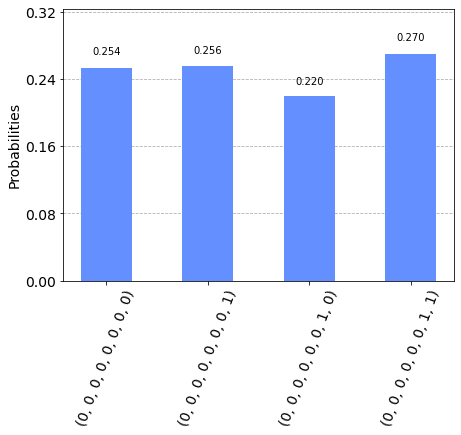

In [31]:
plot_histogram(counts)

The time cost of the QPE algorithm is $O(n \log n)$, where $n= \log{N}$, given by the Quantum Fourier Transform in the algorithm.

In [17]:
render_circuit_jupyter(qft_dagger(4).get_circuit())

Let's just focus on the first state in $C$, and apply the QPE on it

$$
\left| 1 \right >= \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} 1 \left|u_k\right>
$$

$\left| 1 \right >$ is an equal weight superposition of the eigenvectors, so applying QPE on it yields $\phi=\frac{s}{r}$ for a random $s$ with equal probability

Doing it a few times yields a few values of $s$:

$$
\frac{s_1}{r}, \; \frac{s_2}{r}, \; \cdots, \; \frac{s_m}{r} 
$$

From which $r$ can be determined using a (readily available) continued fractions technique.

In [18]:
rows, measured_phases = [], []
for output in counts:

    decimal = "".join(str(ele) for ele in output)
    decimal = int(decimal[::-1],2)

    phase = decimal/(2**n_count)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{decimal}/{2**n_count} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

                            Register Output           Phase
0  (0, 0, 0, 0, 0, 0, 0, 0)(bin) =   0(dec)    0/256 = 0.00
1  (0, 0, 0, 0, 0, 0, 0, 1)(bin) = 128(dec)  128/256 = 0.50
2  (0, 0, 0, 0, 0, 0, 1, 0)(bin) =  64(dec)   64/256 = 0.25
3  (0, 0, 0, 0, 0, 0, 1, 1)(bin) = 192(dec)  192/256 = 0.75


In [19]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.00      0/1            1
1   0.50      1/2            2
2   0.25      1/4            4
3   0.75      3/4            4


In [20]:
def qpe_amod15(a):
    n_count = 8
    qc = Circuit(4+n_count, n_count)
    for q in range(n_count):
        qc.H(q)     # Initialize counting qubits in state |+>
    qc.X(3+n_count) # And auxiliary register in state |1>

    for q in range(n_count): # Do controlled-U operations
        qc.add_qcontrolbox(c_amod15(a, 2**q), [q] + [i+n_count for i in range(4)])
    qc.add_circbox(qft_dagger(n_count), range(n_count)) # Do inverse-QFT

    for i in range(n_count):
        qc.Measure(i, i)
    

    compiled = b.get_compiled_circuit(qc, optimisation_level=0)        # compile the circuit to satisfy the backend's requirements
    handle = b.process_circuit(compiled, 200) 
    readings = b.get_result(handle).get_shots() # retrieve and summarise the results
    # print(readings[0])

    bits = ""

    for i in reversed(readings[0]):
        bits += str(i)

    # print(bits)


    print("Register Reading: " + bits)
    phase = int(bits,2)/(2**n_count)
    print("Corresponding Phase: %f" % phase)
    return phase

In [21]:
a = 7
N=35
factor_found = False
attempt = 0
while not factor_found:
    attempt += 1
    print("\nAttempt %i:" % attempt)
    phase = qpe_amod15(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N) # Denominator should (hopefully!) tell us r
    r = frac.denominator
    print("Result: r = %i" % r)
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print("Guessed Factors: %i and %i" % (guesses[0], guesses[1]))
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0: # Check to see if guess is a factor
                print("*** Non-trivial factor found: %i ***" % guess)
                factor_found = True


Attempt 1:
Register Reading: 00000000
Corresponding Phase: 0.000000
Result: r = 1

Attempt 2:
Register Reading: 00000000
Corresponding Phase: 0.000000
Result: r = 1

Attempt 3:
Register Reading: 10000000
Corresponding Phase: 0.500000
Result: r = 2
Guessed Factors: 1 and 1

Attempt 4:
Register Reading: 10000000
Corresponding Phase: 0.500000
Result: r = 2
Guessed Factors: 1 and 1

Attempt 5:
Register Reading: 11000000
Corresponding Phase: 0.750000
Result: r = 4
Guessed Factors: 1 and 5
*** Non-trivial factor found: 5 ***


### Bibliography
- <a href="https://qiskit.org/textbook/ch-algorithms/shor.html">https://qiskit.org/textbook/ch-algorithms/shor.html</a>
- <a href="https://hiqsimulator.readthedocs.io/en/latest/examples/examples.ShorAlgorithm.html#:~:text=Introduction%20to%20Shor's%20Algorithm,effective%20classical%20factorization%20algorithm%20known.">https://hiqsimulator.readthedocs.io/en/latest/examples/examples.ShorAlgorithm.html#:~:text=Introduction%20to%20Shor's%20Algorithm,effective%20classical%20factorization%20algorithm%20known.</a>
- <a href="https://www.quantiki.org/wiki/shors-factoring-algorithm">https://www.quantiki.org/wiki/shors-factoring-algorithm </a>
- <a href="https://quantum-computing.ibm.com/composer/docs/iqx/guide/shors-algorithm">https://quantum-computing.ibm.com/composer/docs/iqx/guide/shors-algorithm</a>
- <a href="https://jonathan-hui.medium.com/qc-period-finding-in-shors-algorithm-7eb0c22e8202">https://jonathan-hui.medium.com/qc-period-finding-in-shors-algorithm-7eb0c22e8202</a>
- <a href="https://quantumalgorithmzoo.org/">https://quantumalgorithmzoo.org/</a>